# NEW ABSA

In [ ]:
# !pip install pandas numpy matplotlib seaborn plotly nltk spacy textstat vaderSentiment scikit-learn statsmodels scipy transformers torch
# !pip install tqdm
# !pip install xgboost

In [ ]:
# ====================
# DRIVE & WARNINGS
# ====================
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

# ====================
# CORE LIBRARIES
# ====================
import os
import re
import string
from datetime import datetime
from tqdm import tqdm

# ====================
# DATA MANIPULATION
# ====================
import pandas as pd
import numpy as np
import random

# ====================
# VISUALIZATION
# ====================
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import plotly.express as px
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# ====================
# NLP - NLTK
# ====================
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# ====================
# NLP - TEXT ANALYSIS
# ====================
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.manifold import TSNE

# ====================
# MACHINE LEARNING
# ====================
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

# ====================
# DEEP LEARNING / TRANSFORMERS
# ====================
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
from torch.nn.functional import softmax

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# --- MOUNT DRIVE & LOAD DATA ---
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/GP/final_v2.csv')
# df = pd.read_csv('data/final_v2.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (4818, 17)
Columns: ['date', 'title', 'description', 'text', 'author', 'country', 'clean_text', 'current_rate', 'next_rate', 'next_rate_date', 'rate_difference', 'previous_rate', 'rate_change_direction', 'days_to_next_decision', 'quarter', 'year', 'role']


In [ ]:
# Create a function for enhanced text preprocessing
def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return ' '.join(lemmatized)

# Make directory for figures if it doesn't exist
import os
#os.makedirs('/content/drive/MyDrive/GP/Figures', exist_ok=True)

# Apply enhanced preprocessing
df['processed_text'] = df['clean_text'].apply(preprocess_text)

Running Enhanced LDA Analysis...
Vocabulary size: 800
Document-term matrix shape: (4815, 800)
Topic Coherence Analysis:

Topic 1 - Top 5 words:
  inflation, rate, price, monetary policy, percent
  Weight variance: 88230941.5786 (lower = more coherent)

Topic 2 - Top 5 words:
  asset, credit, liquidity, crisis, loan
  Weight variance: 6115974.8461 (lower = more coherent)

Topic 3 - Top 5 words:
  capital, firm, business, community, payment
  Weight variance: 2986654.3395 (lower = more coherent)

Topic 4 - Top 5 words:
  crisis, monetary policy, reform, price stability, currency
  Weight variance: 2193757.4593 (lower = more coherent)


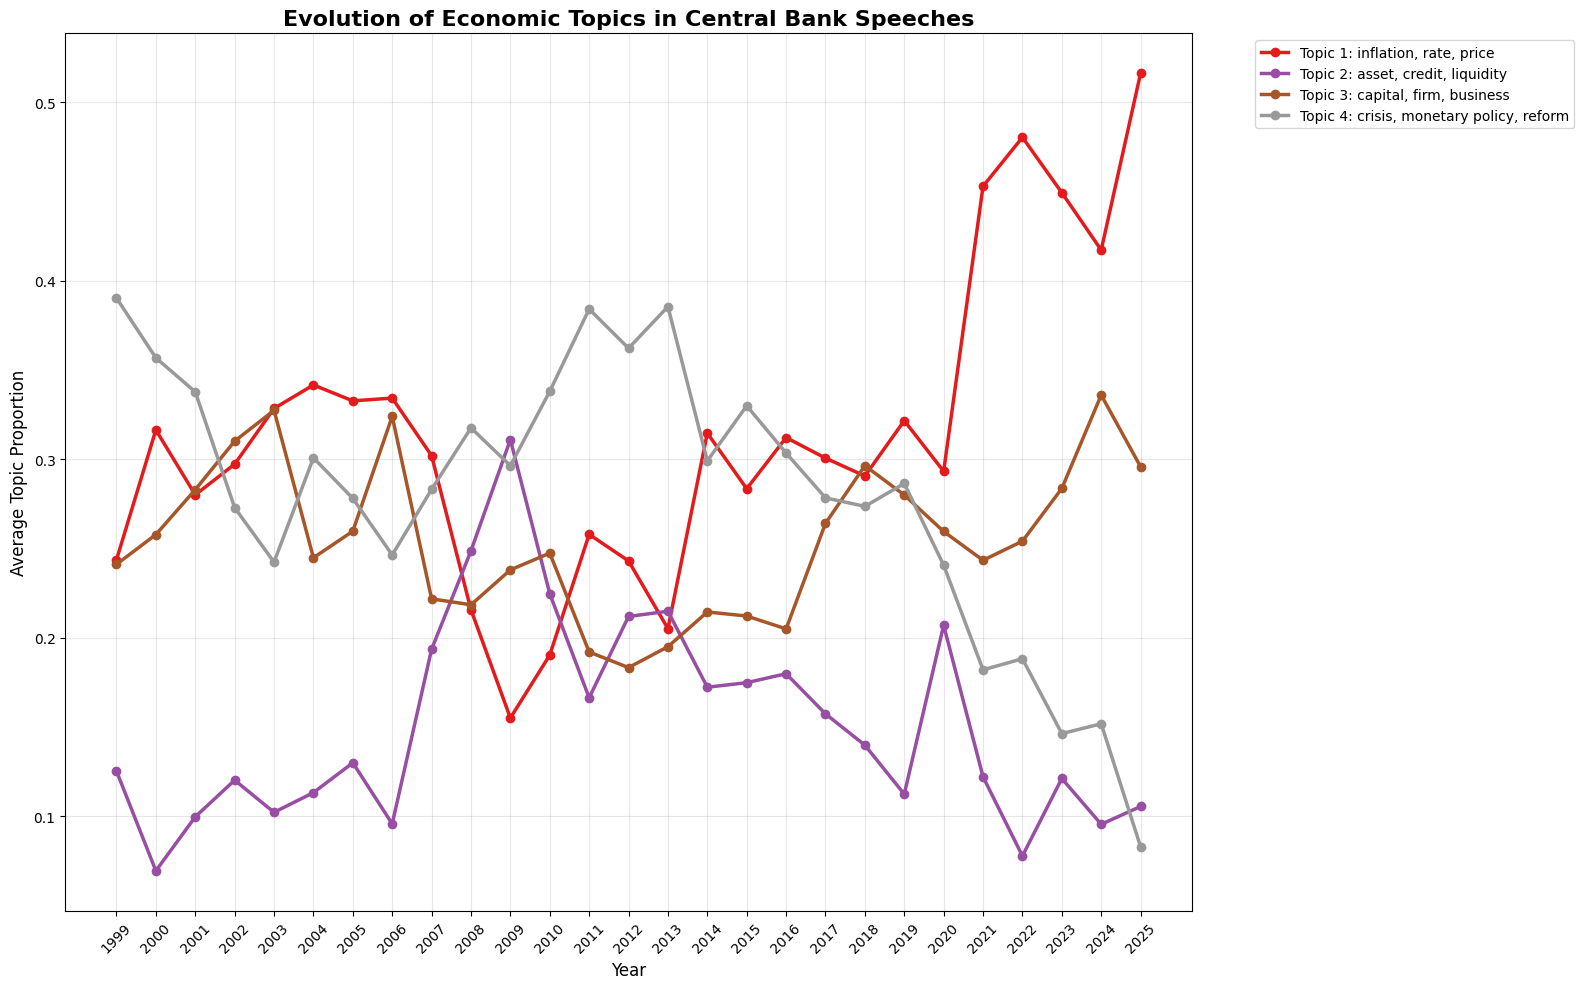


Most Representative Documents by Topic:

Topic 1 - Topic 1: inflation, rate, price
----------------------------------------
  1. Document 171, Probability: 1.000
  2. Document 973, Probability: 1.000
  3. Document 4809, Probability: 1.000

Topic 2 - Topic 2: asset, credit, liquidity
----------------------------------------
  1. Document 1438, Probability: 0.959
  2. Document 4114, Probability: 0.957
  3. Document 2867, Probability: 0.946

Topic 3 - Topic 3: capital, firm, business
----------------------------------------
  1. Document 4433, Probability: 1.000
  2. Document 407, Probability: 1.000
  3. Document 460, Probability: 1.000

Topic 4 - Topic 4: crisis, monetary policy, reform
----------------------------------------
  1. Document 2512, Probability: 0.999
  2. Document 2993, Probability: 0.999
  3. Document 2825, Probability: 0.999


In [ ]:
def create_economic_stopwords():
    """Create domain-specific stopwords to filter out generic terms"""
    # Standard stopwords plus generic economic/speech terms
    generic_terms = [
        # Speech/communication terms
        'said', 'says', 'say', 'saying', 'talk', 'speech', 'remarks', 'comments',
        'today', 'yesterday', 'tomorrow', 'recent', 'recently', 'current', 'currently',
        'important', 'significant', 'however', 'moreover', 'furthermore', 'therefore',

        # Institutional terms (filter out institutional noise)
        'central', 'bank', 'banking', 'federal', 'reserve', 'ecb', 'fed', 'committee',
        'euro', 'area', 'euro_area', 'european', 'europe', 'country', 'countries',
        'national', 'international', 'global', 'domestic', 'region', 'regional',
        'institution', 'institutions', 'authority', 'authorities', 'council',
        'board', 'governors', 'member', 'members', 'states', 'state', 'union',

        # Generic policy/analysis terms
        'policy', 'policymakers', 'monetary', 'economic', 'economy', 'economies',
        'data', 'information', 'evidence', 'analysis', 'research', 'study', 'studies',
        'meeting', 'meetings', 'decision', 'decisions', 'consider', 'considering',
        'view', 'views', 'perspective', 'approach', 'strategy', 'framework',
        'system', 'systems', 'development', 'developments', 'change', 'changes',

        # Time/measurement terms
        'level', 'levels', 'time', 'times', 'period', 'periods', 'year', 'years',
        'month', 'months', 'quarter', 'quarters', 'term', 'terms', 'short', 'long',
        'high', 'low', 'increase', 'decrease', 'rise', 'fall', 'growth', 'decline',

        # Generic descriptors
        'measure', 'measures', 'action', 'actions', 'step', 'steps', 'process',
        'processes', 'mechanism', 'mechanisms', 'tool', 'tools', 'instrument',
        'instruments', 'way', 'ways', 'means', 'method', 'methods'
    ]
    return generic_terms

def create_economic_bigrams(texts):
    """Create economic-specific bigrams to capture multi-word concepts"""
    economic_phrases = [
        r'\binterest rate\b', r'\binterest rates\b',
        r'\binflation target\b', r'\binflation targeting\b',
        r'\bprice stability\b', r'\bprice level\b',
        r'\beconomic growth\b', r'\bgdp growth\b',
        r'\bunemployment rate\b', r'\blabor market\b', r'\bjob market\b',
        r'\bfinancial stability\b', r'\bfinancial system\b',
        r'\bquantitative easing\b', r'\bmonetary policy\b',
        r'\bfiscal policy\b', r'\bfiscal stimulus\b',
        r'\btrade war\b', r'\btrade tensions\b',
        r'\bsupply chain\b', r'\bsupply chains\b',
        r'\benergy prices\b', r'\boil prices\b',
        r'\bhousing market\b', r'\breal estate\b',
        r'\bstock market\b', r'\bequity markets\b',
        r'\bbond market\b', r'\bbond yields\b',
        r'\bexchange rate\b', r'\bcurrency\b',
        r'\bbank lending\b', r'\bcredit conditions\b'
    ]

    processed_texts = []
    for text in texts:
        processed_text = text.lower()
        # Replace phrases with underscore-connected versions
        for phrase in economic_phrases:
            processed_text = re.sub(phrase, lambda m: m.group().replace(' ', '_'), processed_text)
        processed_texts.append(processed_text)

    return processed_texts

def preprocess_for_topics(df, text_column='processed_text'):
    """Enhanced preprocessing for better topic separation"""
    # Filter out very short texts
    df_clean = df[df[text_column].notna() & (df[text_column].str.len() > 100)].copy()

    # Create bigrams for economic concepts
    texts = create_economic_bigrams(df_clean[text_column].tolist())
    df_clean['enhanced_text'] = texts

    return df_clean

def run_enhanced_topic_modeling(df, subset_filter=None, method='lda', n_topics=6, n_top_words=15):
    """Enhanced topic modeling with domain-specific preprocessing"""

    # Preprocessing
    if subset_filter is not None:
        subset = df[subset_filter].copy()
    else:
        subset = df.copy()

    subset = preprocess_for_topics(subset)
    texts = subset['enhanced_text']

    # Enhanced stopwords
    economic_stopwords = create_economic_stopwords()

    # Choose vectorizer with enhanced parameters
    if method == 'lda':
        vectorizer = CountVectorizer(
            max_df=0.8,   # Even more restrictive
            min_df=15,    # Higher minimum to focus on substantial themes
            stop_words=economic_stopwords,
            token_pattern=r'\b[a-zA-Z_]{4,}\b',  # Minimum 4 letters to filter short words
            ngram_range=(1, 2),  # Include unigrams and bigrams
            max_features=800     # Smaller vocabulary for more focused topics
        )
    elif method == 'nmf':
        vectorizer = TfidfVectorizer(
            max_df=0.8,
            min_df=15,
            stop_words=economic_stopwords,
            token_pattern=r'\b[a-zA-Z_]{4,}\b',
            ngram_range=(1, 2),
            max_features=800
        )

    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    print(f"Vocabulary size: {len(feature_names)}")
    print(f"Document-term matrix shape: {X.shape}")

    # Train topic model with enhanced parameters
    if method == 'lda':
        model = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            learning_method='batch',
            doc_topic_prior=0.1,
            topic_word_prior=0.01,
            max_iter=20
        )
    elif method == 'nmf':
        model = NMF(
            n_components=n_topics,
            random_state=42,
            alpha_W=0.1,  # Regularization
            alpha_H=0.1
        )

    model.fit(X)

    # Extract topics with better formatting
    topics = []
    topic_labels = []

    for topic_idx, topic_weights in enumerate(model.components_):
        top_indices = topic_weights.argsort()[:-n_top_words - 1:-1]
        topic_words = [(feature_names[i], topic_weights[i]) for i in top_indices]
        topics.append(topic_words)

        # Auto-generate topic labels based on top words
        top_words = [feature_names[i].replace('_', ' ') for i in top_indices[:3]]
        topic_label = f"Topic {topic_idx+1}: {', '.join(top_words)}"
        topic_labels.append(topic_label)

    return model, vectorizer, topics, topic_labels, X, subset

def plot_enhanced_topics(topics, topic_labels, title, save_path=None):
    """Enhanced topic visualization"""
    n_topics = len(topics)
    n_top_words = min(10, len(topics[0]))  # Show top 10 words max

    n_cols = 2
    n_rows = int(np.ceil(n_topics / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
    if n_topics == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    colors = plt.cm.Set3(np.linspace(0, 1, n_topics))

    for i, (topic, ax, color) in enumerate(zip(topics, axes, colors)):
        words, weights = zip(*topic[:n_top_words])
        # Clean up word display
        display_words = [w.replace('_', ' ').title() for w in words]

        y_pos = np.arange(len(display_words))
        bars = ax.barh(y_pos, weights, align='center', color=color, alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(display_words, fontsize=10)
        ax.invert_yaxis()
        ax.set_title(topic_labels[i], fontsize=12, fontweight='bold')
        ax.set_xlabel('Word Weight', fontsize=10)
        ax.grid(axis='x', alpha=0.3)

    # Hide unused subplots
    for j in range(len(topics), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def analyze_topic_coherence(topics, top_n=5):
    """Analyze topic coherence by looking at word relationships"""
    print("Topic Coherence Analysis:")
    print("=" * 50)

    for i, topic in enumerate(topics):
        print(f"\nTopic {i+1} - Top {top_n} words:")
        top_words = [word.replace('_', ' ') for word, _ in topic[:top_n]]
        print(f"  {', '.join(top_words)}")

        # Calculate word weight variance (lower = more coherent)
        weights = [weight for _, weight in topic[:top_n]]
        weight_var = np.var(weights)
        print(f"  Weight variance: {weight_var:.4f} (lower = more coherent)")

# === Enhanced Analysis ===
print("Running Enhanced LDA Analysis...")
lda_model, lda_vectorizer, lda_topics, lda_labels, lda_X, processed_df = run_enhanced_topic_modeling(
    df, method='lda', n_topics=4, n_top_words=15  # Reduced from 6 to 4
)

#plot_enhanced_topics(lda_topics, lda_labels, "Enhanced LDA Topics - Central Bank Speeches",
 #                   save_path="/content/drive/MyDrive/GP/Figures/enhanced_lda_topics.png")

analyze_topic_coherence(lda_topics)

def analyze_topic_evolution(model, X, processed_df, topic_labels):
    """Analyze how topics evolve over time with better labeling"""
    topic_dist = model.transform(X)

    topic_cols = [f'topic_{i+1}' for i in range(len(topic_labels))]
    topic_df = pd.DataFrame(topic_dist, columns=topic_cols)
    analysis_df = pd.concat([processed_df.reset_index(drop=True), topic_df], axis=1)

    # Yearly topic averages
    yearly_topics = analysis_df.groupby('year')[topic_cols].mean().reset_index().sort_values(by='year')

    # Sort years and ensure all years are displayed
    all_years = yearly_topics['year'].tolist()

    # Plot with better labels
    plt.figure(figsize=(16, 10))
    colors = plt.cm.Set1(np.linspace(0, 1, len(topic_cols)))

    for i, (col, color, label) in enumerate(zip(topic_cols, colors, topic_labels)):
        plt.plot(yearly_topics['year'], yearly_topics[col],
                 marker='o', linewidth=2.5, markersize=6,
                 label=label, color=color)

    plt.title('Evolution of Economic Topics in Central Bank Speeches', fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Topic Proportion', fontsize=12)
    plt.xticks(all_years, rotation=45)  # Show every year, rotated if needed
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    #plt.savefig('/content/drive/MyDrive/GP/Figures/enhanced_topic_evolution.png',
     #           dpi=300, bbox_inches='tight')
    plt.show()

    return yearly_topics

yearly_evolution = analyze_topic_evolution(lda_model, lda_X, processed_df, lda_labels)

# === Topic-Document Analysis ===
def find_representative_documents(processed_df, topic_dist, n_docs=3):
    """Find most representative documents for each topic"""
    print("\nMost Representative Documents by Topic:")
    print("=" * 60)

    for topic_idx in range(topic_dist.shape[1]):
        print(f"\nTopic {topic_idx+1} - {lda_labels[topic_idx]}")
        print("-" * 40)

        # Get documents with highest probability for this topic
        topic_probs = topic_dist[:, topic_idx]
        top_doc_indices = topic_probs.argsort()[-n_docs:][::-1]

        for rank, doc_idx in enumerate(top_doc_indices, 1):
            prob = topic_probs[doc_idx]
            if 'speaker' in processed_df.columns and 'year' in processed_df.columns:
                speaker = processed_df.iloc[doc_idx]['speaker']
                year = processed_df.iloc[doc_idx]['year']
                print(f"  {rank}. Speaker: {speaker}, Year: {year}, Probability: {prob:.3f}")
            else:
                print(f"  {rank}. Document {doc_idx}, Probability: {prob:.3f}")

topic_dist = lda_model.transform(lda_X)
find_representative_documents(processed_df, topic_dist)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import warnings
warnings.filterwarnings('ignore')


# === STEP 1: ASSIGN TOPIC DISTRIBUTIONS TO INDIVIDUAL SPEECHES ===
print("\n" + "="*60)
print("STEP 1: ASSIGNING TOPIC DISTRIBUTIONS TO SPEECHES")
print("="*60)

def assign_topic_distributions(df, model, vectorizer, topic_labels):
    """Assign topic distributions to each speech"""
    # Filter out speeches without processed_text
    df_clean = df[df['processed_text'].notna() & (df['processed_text'].str.len() > 100)].copy()

    # Apply the same preprocessing as used in LDA training
    texts = create_economic_bigrams(df_clean['processed_text'].tolist())

    # Transform texts using the fitted vectorizer
    X = vectorizer.transform(texts)

    # Get topic distributions
    topic_dist = model.transform(X)

    # Add topic distributions to dataframe
    topic_cols = [f'topic_{i+1}_prob' for i in range(len(topic_labels))]
    topic_df = pd.DataFrame(topic_dist, columns=topic_cols)

    # Combine with original dataframe
    result_df = pd.concat([df_clean.reset_index(drop=True), topic_df], axis=1)

    # Add dominant topic
    result_df['dominant_topic'] = topic_dist.argmax(axis=1) + 1
    result_df['dominant_topic_prob'] = topic_dist.max(axis=1)

    print(f"Topic distributions assigned to {len(result_df)} speeches")
    print(f"Topic columns: {topic_cols}")

    return result_df, topic_cols

# Assuming you have the LDA model, vectorizer, and labels from the previous code
# If not, you'll need to run the LDA analysis first
topic_df, topic_columns = assign_topic_distributions(df, lda_model, lda_vectorizer, lda_labels)

print("\nTopic distribution summary:")
for col in topic_columns:
    print(f"{col}: mean={topic_df[col].mean():.3f}, std={topic_df[col].std():.3f}")

# === STEP 2: ASPECT-BASED SENTIMENT ANALYSIS ===
print("\n" + "="*60)
print("STEP 2: ASPECT-BASED SENTIMENT ANALYSIS WITH BERT")
print("="*60)

class AspectBasedSentimentAnalyzer:
    def __init__(self):
        """Initialize BERT-based sentiment analyzer"""
        try:
            # Use a financial/economic sentiment model if available, otherwise use general sentiment
            self.sentiment_analyzer = pipeline(
                "sentiment-analysis",
                model="ProsusAI/finbert",  # Financial BERT model
                tokenizer="ProsusAI/finbert",
                device=0 if torch.cuda.is_available() else -1
            )
        except:
            # Fallback to general sentiment model
            print("FinBERT not available, using general sentiment model...")
            self.sentiment_analyzer = pipeline(
                "sentiment-analysis",
                model="cardiffnlp/twitter-roberta-base-sentiment-latest",
                device=0 if torch.cuda.is_available() else -1
            )

    def extract_topic_segments(self, text, topic_keywords):
        """Extract text segments related to specific topics"""
        sentences = text.split('.')
        topic_sentences = []

        for sentence in sentences:
            sentence = sentence.strip().lower()
            if len(sentence) > 30:  # Minimum sentence length
                # Check if sentence contains topic-related keywords
                for keyword in topic_keywords:
                    if keyword.lower() in sentence:
                        topic_sentences.append(sentence)
                        break

        return ' '.join(topic_sentences) if topic_sentences else text[:512]  # Fallback to beginning of text

    def analyze_sentiment(self, text, max_length=512):
        """Analyze sentiment of text using BERT"""
        if not text or len(text.strip()) == 0:
            return {'label': 'NEUTRAL', 'score': 0.0}

        # Truncate text to model's maximum length
        text = text[:max_length]

        try:
            result = self.sentiment_analyzer(text)[0]

            # Normalize labels across different models
            label = result['label'].upper()
            if 'POSITIVE' in label or 'POS' in label:
                normalized_label = 'POSITIVE'
            elif 'NEGATIVE' in label or 'NEG' in label:
                normalized_label = 'NEGATIVE'
            else:
                normalized_label = 'NEUTRAL'

            return {
                'label': normalized_label,
                'score': result['score']
            }
        except Exception as e:
            print(f"Error in sentiment analysis: {e}")
            return {'label': 'NEUTRAL', 'score': 0.0}

def perform_aspect_sentiment_analysis(df, topic_columns, lda_topics):
    """Perform aspect-based sentiment analysis for each topic"""

    analyzer = AspectBasedSentimentAnalyzer()

    # Create topic keyword mappings from LDA results
    topic_keywords = {}
    for i, topic in enumerate(lda_topics):
        # Get top 10 words for each topic
        keywords = [word.replace('_', ' ') for word, _ in topic[:10]]
        topic_keywords[f'topic_{i+1}'] = keywords

    print("Topic keywords extracted:")
    for topic, keywords in topic_keywords.items():
        print(f"{topic}: {keywords[:5]}")  # Show first 5 keywords

    # Analyze sentiment for each topic aspect
    sentiment_columns = []

    for i in range(1, len(topic_columns) + 1):
        topic_name = f'topic_{i}'

        # Create columns for this topic's sentiment
        sentiment_col = f'{topic_name}_sentiment'
        sentiment_score_col = f'{topic_name}_sentiment_score'
        sentiment_columns.extend([sentiment_col, sentiment_score_col])

        print(f"Analyzing sentiment for {topic_name}...")

        sentiments = []
        scores = []

        for idx, row in df.iterrows():
            if idx % 100 == 0:
                print(f"  Processed {idx}/{len(df)} speeches...")

            text = row['processed_text']
            if pd.isna(text):
                sentiments.append('NEUTRAL')
                scores.append(0.0)
                continue

            # Extract topic-relevant segments
            keywords = topic_keywords.get(topic_name, [])
            topic_text = analyzer.extract_topic_segments(text, keywords)

            # Analyze sentiment
            sentiment_result = analyzer.analyze_sentiment(topic_text)
            sentiments.append(sentiment_result['label'])
            scores.append(sentiment_result['score'])

        df[sentiment_col] = sentiments
        df[sentiment_score_col] = scores

    print(f"\nSentiment analysis completed. Added columns: {sentiment_columns}")
    return df, sentiment_columns

# Perform sentiment analysis
print("Starting aspect-based sentiment analysis...")
sentiment_df, sentiment_columns = perform_aspect_sentiment_analysis(topic_df, topic_columns, lda_topics)

# Display sentiment distribution
print("\nSentiment distribution by topic:")
for i in range(1, len(topic_columns) + 1):
    sentiment_col = f'topic_{i}_sentiment'
    if sentiment_col in sentiment_df.columns:
        print(f"Topic {i}:")
        print(sentiment_df[sentiment_col].value_counts())
        print()

# === STEP 3: PREPARE TARGET VARIABLE ===
print("\n" + "="*60)
print("STEP 3: PREPARING TARGET VARIABLE")
print("="*60)

def create_target_variable(df):
    """Create binary target variable: 1 for rate increase, 0 for rate cut/no change"""
    # Calculate rate difference: positive = increase, negative = decrease, zero = no change
    df['rate_diff'] = df['next_rate'] - df['current_rate']

    # Create binary target: 1 for increase, 0 for cut/no change
    df['target'] = (df['rate_diff'] > 0).astype(int)

    print("Target variable distribution:")
    print(f"Rate increases (target=1): {df['target'].sum()} ({df['target'].mean():.2%})")
    print(f"Rate cuts/no change (target=0): {(1-df['target']).sum()} ({(1-df['target']).mean():.2%})")

    print("\nRate difference distribution:")
    print(f"Rate increases: {(df['rate_diff'] > 0).sum()}")
    print(f"Rate decreases: {(df['rate_diff'] < 0).sum()}")
    print(f"No change: {(df['rate_diff'] == 0).sum()}")

    return df

sentiment_df = create_target_variable(sentiment_df)

# === STEP 4: FEATURE ENGINEERING ===
print("\n" + "="*60)
print("STEP 4: FEATURE ENGINEERING")
print("="*60)

def create_features(df, topic_columns, sentiment_columns):
    """Create features for prediction model"""

    feature_columns = []

    # 1. Topic probabilities
    feature_columns.extend(topic_columns)

    # 2. Sentiment scores (numerical)
    sentiment_score_cols = [col for col in sentiment_columns if 'score' in col]
    feature_columns.extend(sentiment_score_cols)

    # 3. Encode categorical sentiment as numerical
    for i in range(1, len(topic_columns) + 1):
        sentiment_col = f'topic_{i}_sentiment'
        if sentiment_col in df.columns:
            # Create dummy variables for sentiment
            df[f'{sentiment_col}_positive'] = (df[sentiment_col] == 'POSITIVE').astype(int)
            df[f'{sentiment_col}_negative'] = (df[sentiment_col] == 'NEGATIVE').astype(int)
            feature_columns.extend([f'{sentiment_col}_positive', f'{sentiment_col}_negative'])

    # 4. Current rate level
    if 'current_rate' in df.columns:
        feature_columns.append('current_rate')

    # 5. Days to next decision
    if 'days_to_next_decision' in df.columns:
        feature_columns.append('days_to_next_decision')

    # 6. Dominant topic
    if 'dominant_topic' in df.columns:
        # Create dummy variables for dominant topic
        for topic in df['dominant_topic'].unique():
            if not pd.isna(topic):
                df[f'dominant_topic_{int(topic)}'] = (df['dominant_topic'] == topic).astype(int)
                feature_columns.append(f'dominant_topic_{int(topic)}')

    # 7. Text length (as a proxy for speech importance/detail)
    if 'processed_text' in df.columns:
        df['text_length'] = df['processed_text'].str.len()
        feature_columns.append('text_length')

    print(f"Created {len(feature_columns)} features:")
    for i, col in enumerate(feature_columns):
        if i < 20:  # Show first 20 features
            print(f"  {col}")
        elif i == 20:
            print(f"  ... and {len(feature_columns) - 20} more")
            break

    return df, feature_columns

sentiment_df, feature_columns = create_features(sentiment_df, topic_columns, sentiment_columns)

# === STEP 5: TIME-BASED CROSS-VALIDATION AND MODEL TRAINING ===
print("\n" + "="*60)
print("STEP 5: TIME-BASED CROSS-VALIDATION AND MODEL TRAINING")
print("="*60)

def time_based_split(df, n_splits=15):
    """Create time-based splits: train on first 14/15, test on last 1/15"""
    df_sorted = df.sort_values('date').reset_index(drop=True)

    total_samples = len(df_sorted)
    test_size = total_samples // n_splits

    splits = []
    for i in range(n_splits):
        test_start = i * test_size
        test_end = (i + 1) * test_size if i < n_splits - 1 else total_samples

        # Train on all data except the current test fold
        train_indices = list(range(0, test_start)) + list(range(test_end, total_samples))
        test_indices = list(range(test_start, test_end))

        if len(train_indices) > 0 and len(test_indices) > 0:
            splits.append((train_indices, test_indices))

    print(f"Created {len(splits)} time-based splits")
    print(f"Average train size: {np.mean([len(train) for train, _ in splits]):.0f}")
    print(f"Average test size: {np.mean([len(test) for _, test in splits]):.0f}")

    return splits

def train_and_evaluate_models(df, feature_columns, target_column='target'):
    """Train and evaluate models using time-based cross-validation"""

    # Prepare data
    df_clean = df.dropna(subset=feature_columns + [target_column])
    print(f"Clean dataset size: {len(df_clean)} (removed {len(df) - len(df_clean)} rows with missing values)")

    X = df_clean[feature_columns]
    y = df_clean[target_column]

    # Handle any remaining NaN values
    X = X.fillna(0)

    # Create time-based splits
    splits = time_based_split(df_clean)

    # Initialize models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
    }

    # Store results
    results = {model_name: {'accuracies': [], 'precisions': [], 'recalls': [], 'f1s': []}
               for model_name in models.keys()}

    print(f"\nTraining models with {len(splits)} time-based splits...")

    # Cross-validation
    for fold, (train_idx, test_idx) in enumerate(splits):
        print(f"\nFold {fold + 1}/{len(splits)}")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Skip if test set has only one class
        if len(y_test.unique()) < 2:
            print(f"  Skipped - test set has only one class")
            continue

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for model_name, model in models.items():
            # Train model
            if model_name == 'Logistic Regression':
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

            results[model_name]['accuracies'].append(accuracy)
            results[model_name]['precisions'].append(precision)
            results[model_name]['recalls'].append(recall)
            results[model_name]['f1s'].append(f1)

            print(f"  {model_name}: Acc={accuracy:.3f}, Prec={precision:.3f}, Rec={recall:.3f}, F1={f1:.3f}")

    # Print final results
    print("\n" + "="*60)
    print("FINAL CROSS-VALIDATION RESULTS")
    print("="*60)

    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        print(f"  Accuracy:  {np.mean(metrics['accuracies']):.3f} ± {np.std(metrics['accuracies']):.3f}")
        print(f"  Precision: {np.mean(metrics['precisions']):.3f} ± {np.std(metrics['precisions']):.3f}")
        print(f"  Recall:    {np.mean(metrics['recalls']):.3f} ± {np.std(metrics['recalls']):.3f}")
        print(f"  F1-Score:  {np.mean(metrics['f1s']):.3f} ± {np.std(metrics['f1s']):.3f}")

    return results, models, X, y

# Train and evaluate models
results, trained_models, X_final, y_final = train_and_evaluate_models(sentiment_df, feature_columns)

# === STEP 6: FEATURE IMPORTANCE ANALYSIS ===
print("\n" + "="*60)
print("STEP 6: FEATURE IMPORTANCE ANALYSIS")
print("="*60)

def analyze_feature_importance(model, feature_names, top_n=15):
    """Analyze and display feature importance"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)

        print(f"Top {top_n} Most Important Features:")
        print("-" * 50)
        for i, (_, row) in enumerate(feature_importance.head(top_n).iterrows()):
            print(f"{i+1:2d}. {row['feature']:<30} {row['importance']:.4f}")

        return feature_importance
    else:
        print("Model doesn't support feature importance analysis")
        return None

# Analyze feature importance for Random Forest
if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    feature_importance = analyze_feature_importance(rf_model, feature_columns)

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"Dataset processed: {len(sentiment_df)} speeches")
print(f"Features created: {len(feature_columns)}")
print(f"Target distribution: {sentiment_df['target'].value_counts().to_dict()}")
print("Models trained and evaluated with time-based cross-validation")


STEP 1: ASSIGNING TOPIC DISTRIBUTIONS TO SPEECHES
Topic distributions assigned to 4815 speeches
Topic columns: ['topic_1_prob', 'topic_2_prob', 'topic_3_prob', 'topic_4_prob']

Topic distribution summary:
topic_1_prob: mean=0.300, std=0.317
topic_2_prob: mean=0.163, std=0.199
topic_3_prob: mean=0.248, std=0.309
topic_4_prob: mean=0.289, std=0.286

STEP 2: ASPECT-BASED SENTIMENT ANALYSIS WITH BERT
Starting aspect-based sentiment analysis...


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Topic keywords extracted:
topic_1: ['inflation', 'rate', 'price', 'monetary policy', 'percent']
topic_2: ['asset', 'credit', 'liquidity', 'crisis', 'loan']
topic_3: ['capital', 'firm', 'business', 'community', 'payment']
topic_4: ['crisis', 'monetary policy', 'reform', 'price stability', 'currency']
Analyzing sentiment for topic_1...
  Processed 0/4815 speeches...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

  Processed 100/4815 speeches...
  Processed 200/4815 speeches...
  Processed 300/4815 speeches...
  Processed 400/4815 speeches...
  Processed 500/4815 speeches...
  Processed 600/4815 speeches...
  Processed 700/4815 speeches...
  Processed 800/4815 speeches...
  Processed 900/4815 speeches...
  Processed 1000/4815 speeches...
  Processed 1100/4815 speeches...
  Processed 1200/4815 speeches...
  Processed 1300/4815 speeches...
  Processed 1400/4815 speeches...
  Processed 1500/4815 speeches...
  Processed 1600/4815 speeches...
  Processed 1700/4815 speeches...
  Processed 1800/4815 speeches...
  Processed 1900/4815 speeches...
  Processed 2000/4815 speeches...
  Processed 2100/4815 speeches...
  Processed 2200/4815 speeches...
  Processed 2300/4815 speeches...
  Processed 2400/4815 speeches...
  Processed 2500/4815 speeches...
  Processed 2600/4815 speeches...
  Processed 2700/4815 speeches...
  Processed 2800/4815 speeches...
  Processed 2900/4815 speeches...
  Processed 3000/4815 s

In [ ]:
sentiment_df.to_csv('/content/drive/MyDrive/GP/enhanced_sentiment_scores.csv', index=False)
sentiment_df.head()

,date,title,description,text,author,country,clean_text,current_rate,next_rate,next_rate_date,...,topic_2_sentiment_negative,topic_3_sentiment_positive,topic_3_sentiment_negative,topic_4_sentiment_positive,topic_4_sentiment_negative,dominant_topic_1,dominant_topic_4,dominant_topic_3,dominant_topic_2,text_length
0,1999-01-03 00:00:00,Mr Ferguson reviews last year's economic perfo...,"Remarks by Mr Roger W. Ferguson, Jr., a member...",Mr Ferguson reviews last year's economic perfo...,Roger W Ferguson,United States,"Remarks by Mr Roger W. Ferguson, Jr., a member...",4.63,4.76,1999-02-01,...,0,0,0,0,0,1,0,0,0,12921
1,1999-01-07 00:00:00,Mr Duisenberg's opening statement at the press...,Introductory statement by the President of the...,Mr Duisenberg's opening statement at the press...,Willem F Duisenberg,Euro area,Introductory statement by the President of the...,3.00,2.50,1999-04-09,...,0,0,0,0,0,0,1,0,0,17170
2,1999-01-14 00:00:00,Mr Duisenberg discusses the arrival of the eur...,Speech by the President of the European Centra...,Mr Duisenberg discusses the arrival of the eur...,Willem F Duisenberg,Euro area,Speech by the President of the European Centra...,3.00,2.50,1999-04-09,...,0,0,0,0,0,0,1,0,0,16398
3,1999-01-15 00:00:00,Mr Ferguson expresses his views on monetary po...,"Remarks by Mr Roger W. Ferguson, Jr., a member...",Mr Ferguson expresses his views on monetary po...,Roger W Ferguson,United States,"Remarks by Mr Roger W. Ferguson, Jr., a member...",4.63,4.76,1999-02-01,...,0,0,0,0,0,1,0,0,0,13419
4,1999-01-18 00:00:00,Mr Duisenberg's opening statement at the Europ...,Introductory statement by the President of the...,Mr Duisenberg's opening statement at the Europ...,Willem F Duisenberg,Euro area,Introductory statement by the President of the...,3.00,2.50,1999-04-09,...,0,0,0,0,0,0,1,0,0,13814
